Importing Necessary Modules

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk, re, string
from nltk.tokenize import word_tokenize # for Tokenizing the sentnces as tokens
from nltk.stem.porter import PorterStemmer # converting words to their root forms ,speed and simplicity
porter = PorterStemmer() #Create stemmer object
from nltk.corpus import stopwords # For Removing Stop words like < the , an , is ,..etc >
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

About Dataset

In [2]:
# Read the data
df = pd.read_csv("news.csv")

In [3]:
# Get shape and head
print("Total Records: ", df.shape[0])
print("Columns ", df.columns)
df.head()

Total Records:  6335
Columns  Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
# counting the number of missing values in the dataset
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [5]:
# merging the title and text in order to increase amount of input
df["merged"] = df["title"] + " " + df["text"]

In [6]:
# Define Clean Function to fix text
def clean_text(text):

  # Frist converting all letters to lower case
  text= text.lower()
  
  # removing unwanted digits ,special chracters from the text
  text= ' '.join(re.sub("(@[A-Za-z0-9]+)", " ", text).split()) #tags
  text= ' '.join(re.sub("^@?(\w){1,15}$", " ", text).split())
    
  text= ' '.join(re.sub("(\w+:\/\/\S+)", " ", text).split())   #Links
  text= ' '.join(re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ", text).split()) 
  text= ' '.join(re.sub(r'http\S+', '',text).split())
  
  
  text= ' '.join(re.sub("\s+", " ",text).split()) #Extrem white Space
  text= ' '.join(re.sub("[^-9A-Za-z ]", "" ,text).split()) #digits 
  text= ' '.join(re.sub('-', ' ', text).split()) 
  text= ' '.join(re.sub('_', ' ', text).split())
  
  # Split Sentence as tokens words 
  tokens = word_tokenize(text)
  
  # converting words to their root forms by STEMMING THE WORDS 
  stemmed = [porter.stem(word) for word in tokens]
  
  # Delete each stop words from English stop words
  words = [w for w in stemmed if not w in stopwords.words('english')]
  text  = ' '.join(words)
    
  return text

In [7]:
# apply Clean Function to our Text
df.text =[clean_text(x) for x in df["merged"]]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


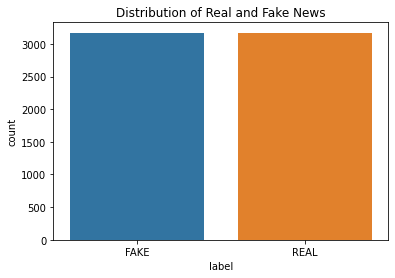

In [8]:
# Get the labels
labels = df.label
labels.head()

sns.countplot(df.label)
plt.title("Distribution of Real and Fake News")
plt.show()

TFIDF Vectorizer

In [9]:
# Split the dataset
x_train,x_test,y_train,y_test = train_test_split(df["text"], labels, test_size=0.2, stratify=labels, shuffle=True, random_state=42)

# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.7)

# Fit and transform train set, transform test set
tfidf_vec = tfidf_vectorizer.fit(x_train) 
tfidf_train = tfidf_vec.transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

In [11]:
# Initialize a PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

# Predict on the test set and calculate accuracy
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.92%


In [12]:
# Build confusion matrix
confusion_matrix(y_test,y_pred, labels=['FAKE','REAL'])

cls_rep = classification_report(y_test, y_pred)
print(cls_rep)

              precision    recall  f1-score   support

        FAKE       0.96      0.92      0.94       633
        REAL       0.92      0.96      0.94       634

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267



Count Vectorizer

In [13]:
# Initialize a TfidfVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.7)

# Fit and transform train set, transform test set
count_vec = count_vectorizer.fit(x_train) 
count_train = count_vec.transform(x_train)
count_test = count_vectorizer.transform(x_test)

In [14]:
# Initialize a PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(count_train,y_train)

# Predict on the test set and calculate accuracy
y_pred = pac.predict(count_test)
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%') 

Accuracy: 91.48%


In [15]:
# Build confusion matrix
confusion_matrix(y_test,y_pred, labels=['FAKE','REAL'])

cls_rep = classification_report(y_test, y_pred)
print(cls_rep)

              precision    recall  f1-score   support

        FAKE       0.92      0.91      0.91       633
        REAL       0.91      0.92      0.91       634

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



10-fold cross validation

In [16]:
corpus = df['text']
y = labels

def evaluate_models(corpus, y, vect=CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.7), model=PassiveAggressiveClassifier(), n_splits=10):
  kf = KFold(n_splits=10, shuffle=True)
  acc_performances = []
  for train_index, test_index in kf.split(corpus,y):
    corpus_train = corpus[train_index]
    corpus_test = corpus[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    # vectorization process
    vect.fit(corpus_train)
    X_train = vect.transform(corpus_train)
    X_test = vect.transform(corpus_test)
    # train model
    model.fit(X_train, y_train)
    # test model => get predictions
    y_pred = model.predict(X_test)
    # compute performance
    acc = accuracy_score(y_test, y_pred)
    acc_performances.append(acc)
    return np.mean(acc_performances)

In [17]:
pac_perf1 = evaluate_models(corpus, y)
print(f'Passive Agressive Model with Count Vectorizer 10-fold Accuracy {pac_perf1}')

Passive Agressive Model with Count Vectorizer 10-fold Accuracy 0.916403785488959


In [18]:
pac_perf2 = evaluate_models(corpus, y, vect = TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.7))
print(f'Passive Agressive Model with TFIDF Vectorizer 10-fold Accuracy {pac_perf2}')

Passive Agressive Model with TFIDF Vectorizer 10-fold Accuracy 0.9227129337539433


In [19]:
dt_perf1 = evaluate_models(corpus, y, model = DecisionTreeClassifier())
print(f'Decision Tree Model with Count Vectorizer 10-fold Accuracy {dt_perf1}')

Decision Tree Model with Count Vectorizer 10-fold Accuracy 0.8249211356466877


In [20]:
dt_perf2 = evaluate_models(corpus, y, model = DecisionTreeClassifier(), vect = TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.7))
print(f'Decision Tree Model with TFIDF Vectorizer 10-fold Accuracy {dt_perf2}')

Decision Tree Model with TFIDF Vectorizer 10-fold Accuracy 0.7649842271293376


In [21]:
knn_perf1 = evaluate_models(corpus, y, model = KNeighborsClassifier(n_neighbors=5,algorithm='brute'))
print(f'KNeighbors Model with Count Vectorizer 10-fold Accuracy {knn_perf1}')

KNeighbors Model with Count Vectorizer 10-fold Accuracy 0.7728706624605678


In [22]:
knn_perf2 = evaluate_models(corpus, y, model = KNeighborsClassifier(n_neighbors=5,algorithm='brute'), vect = TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.7))
print(f'KNeighbors Model with TFIDF Vectorizer 10-fold Accuracy {knn_perf2}')

KNeighbors Model with TFIDF Vectorizer 10-fold Accuracy 0.8643533123028391


In [23]:
results = pd.DataFrame([["Passive Agressive Model with Count Vectorizer",pac_perf1],["Passive Agressive Model with TFIDF Vectorizer",pac_perf2],["Decision Tree Model with Count Vectorizer",dt_perf1],
                       ["Decision Tree Model with TFIDF Vectorizer",dt_perf2],["KNeighbors Model with Count Vectorizer",knn_perf1],["KNeighbors Model with TFIDF Vectorizer",knn_perf2]],columns=["Model","Accuracy"])

results

,Model,Accuracy
0,Passive Agressive Model with Count Vectorizer,0.916404
1,Passive Agressive Model with TFIDF Vectorizer,0.922713
2,Decision Tree Model with Count Vectorizer,0.824921
3,Decision Tree Model with TFIDF Vectorizer,0.764984
4,KNeighbors Model with Count Vectorizer,0.772871
5,KNeighbors Model with TFIDF Vectorizer,0.864353


From the above results, it appears that Passive Agressive Model with TFIDF Vectorizer gives the highest accuracy amongst various models.